In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

This notebook is for expression data for a yeast display library of coiled coil designs with C-terminal myc tag, sorted into myc positve and myc negative populations. Enrichment in myc positive sample over the unsorted library, or in myc positive over myc negative is an indicator of high surface display. 

In [25]:
###USER DEFINED VARIABLES####
outdir = '/Users/stephaniecrilly/Kortemme_lab/switch_seq'
lib_name = 'r1-hs-pilot'
rep = 'rep1'
#import dfs
ordered_seqs_df = pd.read_csv('/Users/stephaniecrilly/Kortemme_lab/helix_sliding/20240304_ngs_data/20240304_all_seqs_r1_order.csv')
myc_pos_df = pd.read_csv('/Users/stephaniecrilly/Kortemme_lab/helix_sliding/20240304_ngs_data/30-991152039/UniqueSeq/r1-hs-mycpos_Unique_AA.csv')
myc_neg_df = pd.read_csv('/Users/stephaniecrilly/Kortemme_lab/helix_sliding/20240304_ngs_data/30-991152039/UniqueSeq/r1-hs-mycneg_Unique_AA.csv')
ns_df  = pd.read_csv('/Users/stephaniecrilly/Kortemme_lab/helix_sliding/20240304_ngs_data/30-991152039/UniqueSeq/r1-hs-ns_Unique_AA.csv')

In [26]:
#drop na
myc_pos_df = myc_pos_df.dropna()
myc_neg_df = myc_neg_df.dropna()
ns_df = ns_df.dropna()

#get only design sequences of interest
#search translated seqs for ones which start and end with flanking aa
mys_pos_df = myc_pos_df[myc_pos_df['Unique Amino Acid'].str.startswith('SASHM')]
mys_ned_df = myc_neg_df[myc_neg_df['Unique Amino Acid'].str.startswith('SASHM')]
ns_df = ns_df[ns_df['Unique Amino Acid'].str.startswith('SASHM')]

myc_pos_df = myc_pos_df[myc_pos_df['Unique Amino Acid'].str.endswith('LEGGG')]
myc_neg_df = myc_neg_df[myc_neg_df['Unique Amino Acid'].str.endswith('LEGGG')]
ns_df = ns_df[ns_df['Unique Amino Acid'].str.endswith('LEGGG')]

#append trailing amino acid to ordered seqs
ordered_seqs_df['sequence'] = 'SASHM' + ordered_seqs_df['aa_sequence'].astype(str) + 'LEGGG'

#get only seqs in library
myc_pos_df = pd.merge(ordered_seqs_df, myc_pos_df, left_on='sequence', right_on='Unique Amino Acid', how='inner')
myc_neg_df = pd.merge(ordered_seqs_df, myc_neg_df, left_on='sequence', right_on='Unique Amino Acid', how='inner')
ns_df = pd.merge(ordered_seqs_df, ns_df, left_on='sequence', right_on='Unique Amino Acid', how='inner')

myc_pos_df = myc_pos_df.drop('Unique Amino Acid', axis=1)
myc_neg_df = myc_neg_df.drop('Unique Amino Acid', axis=1)
ns_df = ns_df.drop('Unique Amino Acid', axis=1)

print(f'{myc_pos_df.shape[0]} seqs represented in myc pos sample out of {ordered_seqs_df.shape[0]} total ordered seqs')
print('Missing in myc pos sample:')
for seq in ordered_seqs_df['sequence']:
    if seq not in myc_pos_df['sequence'].tolist():
        print(ordered_seqs_df.loc[ordered_seqs_df['sequence'] == seq, 'Name'].item())

print(f'{myc_neg_df.shape[0]} seqs represented in myc neg sample out of {ordered_seqs_df.shape[0]} total ordered seqs')
print('Missing in myc neg sample:')
for seq in ordered_seqs_df['sequence']:
    if seq not in myc_neg_df['sequence'].tolist():
        print(ordered_seqs_df.loc[ordered_seqs_df['sequence'] == seq, 'Name'].item())

print(f'{ns_df.shape[0]} seqs represented in unsorted sample out of {ordered_seqs_df.shape[0]} total ordered seqs')
print('Missing in unsorted sample:')
for seq in ordered_seqs_df['sequence']:
    if seq not in ns_df['sequence'].tolist():
        print(ordered_seqs_df.loc[ordered_seqs_df['sequence'] == seq, 'Name'].item())

#add column for condition 
norm_condition = 'unsorted'
coi_1 = 'myc_pos'
coi_2 = 'myc_neg'

coi_1_df = myc_pos_df
coi_2_df = myc_neg_df
norm_condition_df = ns_df

norm_condition_df['Sort_condition'] = norm_condition
coi_1_df['Sort_condition'] = coi_1
coi_2_df['Sort_condition'] = coi_2


94 seqs represented in myc pos sample out of 97 total ordered seqs
Missing in myc pos sample:
07439_ALFA_52_6_min_2_52_bm01_loop
08032_ALFA_53_9_min_2_53_bm01_loop
07739_ALFA_53_5_min_2_53_bm01_loop
93 seqs represented in myc neg sample out of 97 total ordered seqs
Missing in myc neg sample:
11535_ALFA_52_10_min_0_52_bm01_loop
08032_ALFA_53_9_min_2_53_bm01_loop
07739_ALFA_53_5_min_2_53_bm01_loop
08643_ALFA_53_3_min_2_53_bm01_loop
97 seqs represented in unsorted sample out of 97 total ordered seqs
Missing in unsorted sample:


In [27]:
#norm all counts to total counts
norm_condition_df[f'norm_counts_{norm_condition}'] = norm_condition_df[' Unique Amino Acid Count'] /  norm_condition_df[' Unique Amino Acid Count'].sum()
coi_1_df[f'norm_counts_{coi_1}'] = coi_1_df[' Unique Amino Acid Count'] /  coi_1_df[' Unique Amino Acid Count'].sum()
coi_2_df[f'norm_counts_{coi_2}'] = coi_2_df[' Unique Amino Acid Count'] /  coi_2_df[' Unique Amino Acid Count'].sum()

merge_df = pd.merge(norm_condition_df, coi_1_df, on=['Name', 'sequence', 'aa_sequence'])
merge_df = pd.merge(merge_df, coi_2_df, on=['Name', 'sequence', 'aa_sequence'])

#norm myc pos to unsorted
merge_df[f'{coi_1}_norm_to_{norm_condition}'] = merge_df[f'norm_counts_{coi_1}'] /  merge_df[f'norm_counts_{norm_condition}']
merge_df[f'{coi_1}_norm_to_{norm_condition}_log'] = np.log2(merge_df[f'{coi_1}_norm_to_{norm_condition}'])

#norm myc pos to myc neg
merge_df[f'{coi_1}_norm_to_{coi_2}'] = merge_df[f'norm_counts_{coi_1}'] /  merge_df[f'norm_counts_{coi_2}']
merge_df[f'{coi_1}_norm_to_{coi_2}_log'] = np.log2(merge_df[f'{coi_1}_norm_to_{coi_2}'])

merge_df = merge_df[['Name', 'sequence', 'aa_sequence', f'norm_counts_{norm_condition}', f'norm_counts_{coi_1}', f'norm_counts_{coi_2}', f'{coi_1}_norm_to_{norm_condition}', f'{coi_1}_norm_to_{norm_condition}_log', f'{coi_1}_norm_to_{coi_2}', f'{coi_1}_norm_to_{coi_2}_log']]

merge_df[['min_type']] = merge_df['Name'].str.split(r'ALFA_\d\d_\d{1,2}_').str[1]
merge_df[['loop_type']] = merge_df['Name'].str.split(r'min_\d_\d\d_').str[1]
merge_df.to_csv(f'{outdir}/{lib_name}_{rep}_expression.csv')


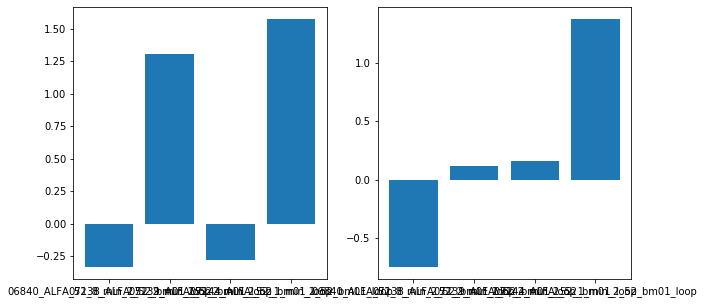

<Figure size 432x288 with 0 Axes>

In [28]:
#plot
min_type = 2 #0 or 2
alfa_thread_pos = 52 #52 or 53
loop = 'bm01' #g4s or bm01

plt.subplots(1, 2, sharey=True, figsize=(10,5))
plt.subplot(1,2,1)
plotting_df = merge_df.query(f"min_type == 'min_{min_type}_{alfa_thread_pos}_{loop}_loop'", engine='python').copy()
plt.bar(x=plotting_df['Name'], height=plotting_df['myc_pos_norm_to_unsorted_log'])
plt.subplot(1,2,2)
plt.bar(x=plotting_df['Name'], height=plotting_df['myc_pos_norm_to_myc_neg_log'])
plt.show()
plt.clf()